NetCDF data shape: (57, 720, 1440)
Zarr data shape: (57, 720, 1440)
Absolute Difference - Mean: 0.0, Median: 0.0, Std: 0.0
Relative Difference - Mean: 0.0, Median: 0.0, Std: 0.0


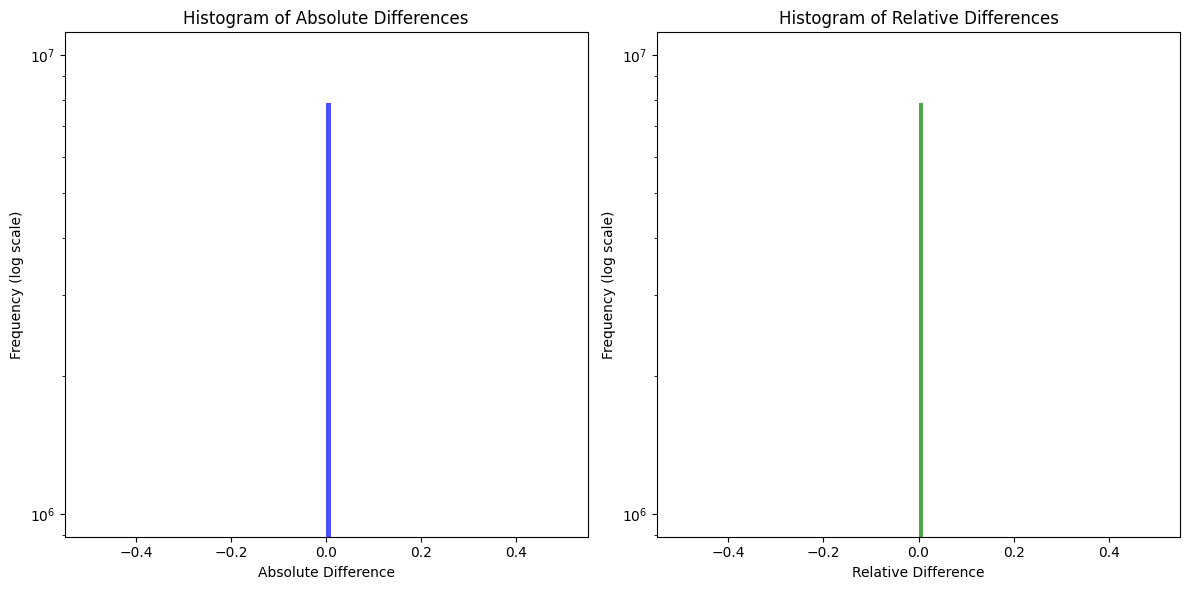

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load Zarr data
data_dir = '../data'
datax = f'{data_dir}/test'
zarr_ds = xr.open_zarr(datax, consolidated=False)

# Select temperature data
param = 'salinity' #'temperature'
param_key = 's' #'t'
time_period = '2'  # Use numeric key as a string
padded_period = time_period.zfill(2)

# Load NetCDF data
netcdf_file = f"../tmp_data/woa23_decav_{param_key}{padded_period}_04.nc"
nc_ds = xr.open_dataset(netcdf_file, decode_times=False)

# Ensure the parameters and time periods exist
if param in zarr_ds.parameters.values and time_period in zarr_ds.time_periods.values:
    # Extract data
    netcdf_data = nc_ds[f"{param_key}_mn"].squeeze()  # Assuming 't_mn' is the temperature variable in NetCDF and squeeze the time dimension
    zarr_data = zarr_ds.sel(parameters=param, time_periods=time_period)['mn']

    # Mask NaN values
    netcdf_values = netcdf_data.values
    zarr_values = zarr_data.values

    # Debugging statements to check shapes and some values
    print("NetCDF data shape:", netcdf_values.shape)
    print("Zarr data shape:", zarr_values.shape)

    # Ensure dimensions match for valid comparison
    if netcdf_values.shape == zarr_values.shape:
        # Create a mask for non-NaN values in both NetCDF and Zarr datasets
        valid_mask = np.isfinite(netcdf_values) & np.isfinite(zarr_values)

        # Apply the mask to both datasets
        netcdf_values_masked = np.where(valid_mask, netcdf_values, np.nan)
        zarr_values_masked = np.where(valid_mask, zarr_values, np.nan)

        # Filter small values for relative difference calculation
        small_value_threshold = 1e-3
        valid_for_rel_diff = valid_mask & (np.abs(netcdf_values_masked) > small_value_threshold)

        # Calculate absolute and relative differences
        abs_diff = np.abs(netcdf_values_masked - zarr_values_masked)
        rel_diff = np.where(valid_for_rel_diff, np.abs(netcdf_values_masked - zarr_values_masked) / np.abs(netcdf_values_masked), np.nan)

        # Identify indices with differences
        diff_mask = (netcdf_values_masked != zarr_values_masked) & valid_mask
        diff_indices = np.where(diff_mask)

        # Print differences
        if np.any(diff_mask):
            print("Differences found at indices:", diff_indices)
            for idx in range(min(10, len(diff_indices[0]))):  # Only show the first 10 differences
                d, la, lo = diff_indices[0][idx], diff_indices[1][idx], diff_indices[2][idx]
                print(f"Index (depth: {d}, lat: {la}, lon: {lo}) - NetCDF value: {netcdf_values[d, la, lo]}, Zarr value: {zarr_values[d, la, lo]}")

        # Compute statistics
        mean_abs_diff = np.nanmean(abs_diff)
        median_abs_diff = np.nanmedian(abs_diff)
        std_abs_diff = np.nanstd(abs_diff)

        mean_rel_diff = np.nanmean(rel_diff)
        median_rel_diff = np.nanmedian(rel_diff)
        std_rel_diff = np.nanstd(rel_diff)

        print(f"Absolute Difference - Mean: {mean_abs_diff}, Median: {median_abs_diff}, Std: {std_abs_diff}")
        print(f"Relative Difference - Mean: {mean_rel_diff}, Median: {median_rel_diff}, Std: {std_rel_diff}")

        # Visualize the differences
        plt.figure(figsize=(12, 6))

        # Plot absolute differences
        plt.subplot(1, 2, 1)
        plt.hist(abs_diff[valid_mask].flatten(), bins=100, color='blue', alpha=0.7, log=True)
        plt.title('Histogram of Absolute Differences')
        plt.xlabel('Absolute Difference')
        plt.ylabel('Frequency (log scale)')

        # Plot relative differences
        plt.subplot(1, 2, 2)
        plt.hist(rel_diff[valid_for_rel_diff].flatten(), bins=100, color='green', alpha=0.7, log=True)
        plt.title('Histogram of Relative Differences')
        plt.xlabel('Relative Difference')
        plt.ylabel('Frequency (log scale)')

        plt.tight_layout()
        plt.show()
    else:
        print("The dimensions of the NetCDF and Zarr datasets do not match.")
else:
    print("Parameter or time period not found in the Zarr dataset.")
